In [42]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import scipy.signal as sgn
from scipy.optimize import minimize

In [43]:
def contour_points_v2(g_img):

    kernel = np.ones((15, 15), np.uint8)
    gradient = cv2.morphologyEx(g_img, cv2.MORPH_GRADIENT, kernel)
    
    blur = cv2.GaussianBlur(gradient + 20, (5, 5), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    gradient_img = np.zeros_like(g_img, dtype=np.uint8)

    contours, _ = cv2.findContours(th3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) < 1:
        return None
    
    cv2.drawContours(gradient_img, contours, -1, 255, 2)

    kernel = np.ones((25, 25),np.uint8)
    gradient_img = cv2.dilate(gradient_img, kernel, iterations = 1)    


    hull_img = np.zeros_like(g_img, dtype=np.uint8)

    blur = cv2.GaussianBlur(g_img, (3, 3), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(th3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) < 1:
        return None
    
    area_cntrs = [cv2.contourArea(cnt) for cnt in contours]
    max_cntr_index = np.argmax(area_cntrs)
    cnt = contours[max_cntr_index]

    hull = cv2.convexHull(cnt)
    cv2.drawContours(hull_img, [hull], 0, 125, 2)

    op = np.logical_and(gradient_img, hull_img).astype(np.uint8)*255

#     op[:10, :] = 0
#     op[-10:, :] = 0

#     kernel = np.ones((3, 3), np.uint8)
#     opening = cv2.morphologyEx(op, cv2.MORPH_OPEN, kernel)
    

#     final_cnt = np.take(final_cnt, list(set(np.random.randint(0, final_cnt.shape[0], size=int(final_cnt.shape[0]/10)))), axis=0)
#     imgs = np.hstack([gradient_img, hull_img, opening])
    
#     if final_cnt.shape[0] > 4:
#         return op
    
#     else:
#         return None
    return op

In [44]:

# Ivo's implemetation of Ellipse class

class Ellipse:

    C : np.array #homogeneous conic matrix x'*C*x=0

    def __init__( self, C : np.array ):

        self.C = C
        

    @classmethod
    def estimate_ellipsoid( cls, points : np.array ):
        """
        C = estimate_ellipsoid_2D ( points )
        ----------------------------------

        estimates a homogeneous ellipsoid C
        
        x'*C*x = 0
        
        from a number of point samples 
        (in a least squares sense)
        
        format of points

                [ x^1_1 . . . . .  x^N_1 ] 
                [  .                 .   ]
        points = [  .                 .   ]
                [  .                 .   ]
                [ x^1_n . . . . .  x^N_n ]
                [  1    . . . . .    1   ]

        where each point is element R^n
        and there are N points, the points  
        have to be in homogeneous coordinates.
        
        """

        n = points.shape[0]
        num_entries = int((n+1) * n/2)
        
        if points.shape[1] < num_entries-1:
            print('insufficient number of points, need at least {}'.format( num_entries-1 ) )
    
        # --------------  estimate ellipse ---------------

        # assemble linear system
        A = np.zeros( [points.shape[ 1 ], num_entries ] )

        #for all points
        for i in range( 0, points.shape[ 1 ] ):
        
            #extract point
            x = np.array([points[:, i]]).T
            #print(x)
            X  = np.matmul( x, x.T )
            #print(X)
            X2 = X.T + X - np.diag( np.diag( X ) )

            #print(X2)
            row = X2[ np.where( np.triu( np.ones( X2.shape ) ) ) ]
            #print(row)

            A[ i, : ] = row

        #print(A)

        #solve for null space 
        U,D,V = np.linalg.svd( A )

        ell = V[-1,:]


        #create conic matrix
        Cd = np.zeros( X2.shape )

        Cd[ np.where( np.triu( np.ones( X2.shape ) ) ) ] = ell

        C = Cd + Cd.T - np.diag( np.diag ( Cd ) )

        #detC =  np.linalg.det( C[0:-1,0:-1] )

        #print(detC)

        if Ellipse.is_hyperboloid( C ):
            print('Warning: result is a hyperboloid!')
        

        if Ellipse.is_paraboloid( C ):
            print('Warning: result is a paraboloid!')
        
        return C

    @classmethod
    def cov_mean_to_ellipsoid( cls, cov, mean, k ):
        """
            C = cov_mean_to_ellipsoid_homog ( Cov, Mean, k )
            ----------------------------------
        
            generates a homogeneous ellipsoid C
            
            x'*C*x = 0
        
            from covariance matrix and mean value
            of a gaussian distribution
            
            k is a confidence factor determibed by the chi^2 
            distribution. The probability that x is inside 
            the ellipsoid is P_{chi^2}(k,2). Some values 
            for k are 2.41 (70%) and k=5.99 (95%).
            
            cov  : np.array - covariance matrix (non-homogeneous)
            mean : np.array - mean value (vector)
            k : float - confidence factor, see above 

        """

        #column vector, assume we get a 1D array
        mean = np.array( [mean] ).T

        SIGMAinv = np.linalg.inv( cov )

        lastentry = np.matmul( mean.T, np.matmul( SIGMAinv, mean ) ) - k 
        C = np.vstack( [ np.hstack( [ SIGMAinv, -np.matmul(SIGMAinv, mean)] ), 
                         np.hstack( [ -np.matmul(mean.T,SIGMAinv), lastentry] ) ] )
        
        return C

    @classmethod
    def srt_to_ellipsoid( cls, S, R, T ): 
        """
         C = srt_to_ellipsoid_homog ( S, R, T )
         ----------------------------------
        
         generates a homogeneous ellipsoid C
         
         x'*C*x = 0
        
         from translation, rotation and scale parts as
        
         x'* (T^-1 * R^-1 * S^-1) ( S * R * T ) x = 0
        
         see: Ivo Ihrke: "Some Notes on Ellipses", TechReport, 2004
        """
        #function C = srt_to_ellipsoid_homog ( S, R, T )


        invT = np.linalg.inv( T )
        invR = R.T
        invS = np.linalg.inv( S )

        left  = np.matmul( invT.T, np.matmul( invR.T, invS.T ) )
        right = np.matmul( invS, np.matmul( invR, invT ) )

        C = np.matmul( left, right )
    
        return C



    @classmethod
    def decompose_ellipsoid( cls, C ):
        """
        
         [S,R,T] = decompose_ellipsoid_homog ( C )
         ----------------------------------
        
         decomposes a homogeneous ellipsoid C
         
         x'*C*x = 0
        
         into translation, rotation and scale parts
        
         x'* (T^-1 * R^-1 * S^-1) ( S * R * T ) x = 0
        
         Note that C \neq (T^-1 * R^-1 * S^-1) ( S * R * T )
         in some cases because the orientation of 
         the ellipsoid's major axis is not fixed.
         The function generates a right handed system.

        """

        #print(C)
        C_ih = C[0:-1,0:-1] 
        #print(C_ih)

        t = -np.matmul( np.linalg.pinv( C_ih ), C[0:-1,-1] )

        T = np.eye( C.shape[ 0 ] )
        T[0:-1, -1 ] = t

        U,D,V = np.linalg.svd( C_ih )

        R = np.eye( C.shape[ 0 ] )
        R[0:-1,0:-1] = V


        #S = R' * T' * C * T * R;
        S = np.matmul( R.T, np.matmul( T.T, np.matmul( C, np.matmul( T, R ) ) ) )

        S = S / S[-1,-1]

        S = np.sqrt( np.diag(1/abs(np.diag(S))))

        return S, R, T

    @classmethod
    def is_ellipsoid( cls, C ):
        """
         bool = is_ellipsoid_homog ( C )
         ----------------------------------
        
         determines whether homogeneous conic C
         
         x'*C*x = 0
         
         is an ellipsoid
        """

        #function val = conic_is_ellipsoid_homog ( C )

        detC =  np.linalg.det( C[0:-1,0:-1] )

        return detC > 0


    @classmethod
    def is_hyperboloid( cls, C ):
        """
         bool = is_hyperboloid_homog ( C )
         ----------------------------------
        
         determines whether homogeneous conic C
         
         x'*C*x = 0
         
         is a hyperboloid
        """

        
        detC =  np.linalg.det( C[0:-1,0:-1] )

        return detC < 0

    @classmethod
    def is_paraboloid( cls, C ):
        """
         bool = is_paraboloid_homog ( C )
         ----------------------------------
        
         determines whether homogeneous conic C
         
         x'*C*x = 0
         
         is a paraboloid
        """

        
        detC =  np.linalg.det( C[0:-1,0:-1] )

        #maybe with EPS ?
        return detC == 0


    def get_center( self ):
        
        S,R,T = self.decompose_ellipsoid( self.C )


        return [ T[2,0], T[2,1] ]


    def plot( self, ax, **kwargs ):
        """
        plot_ellipsoid_2D ( C, style, N )
        ----------------------------------
        
        plots a homogeneous ellipsoid C
        
        x'*C*x = 0
        
        style is a matlab plot style, e.g. 'b-' (default)
        N is the number of polygon segments to 
        approximate the ellipse
        """

        #function plot_ellipsoid_homog_2d ( C, style, N )

        if not 'style' in locals():
            style = 'b-'

        if not 'N' in locals():
            N = 100



        angles = np.linspace( -np.pi, np.pi, N )

        # generate a unit circle or a unit hyperbola
        if ( Ellipse.is_ellipsoid( self.C ) ):
            #uc  = [ cos(x); sin(x); ones(size(x)) ];
            x  = np.cos( angles )
            y  = np.sin( angles )
            w  = np.ones( angles.shape )

            uc = np.vstack([x,y,w])

        else:
            EPS = 0.1
            x   =  np.linspace( -np.pi/2+EPS, np.pi/2-EPS, int( N/2 ) )#-(pi/2-EPS):((pi-2*EPS)/(N/2)):(pi/2-EPS);
            x2  =  np.linspace( np.pi/2+EPS, 3*np.pi/2-EPS, int( N/2 ) )  #x2 =  (pi/2+EPS):((pi-2*EPS)/(N/2)):(3*pi/2-EPS);
            uc  = np.vstack( [ 1/np.cos(x), np.tan(x), np.ones( x.shape ) ] )
            uc2 = np.vstack( [ 1/np.cos(x2), np.tan(x2), np.ones( x2.shape ) ] )
        
        #decompose
        S,R,T = Ellipse.decompose_ellipsoid( self.C )

        #transform unit circle or parabola 
        transform = np.matmul( T, np.matmul( R, S ) )
        ell  =  np.matmul( transform, uc )

        if 'uc2' in locals():
            ell2  =  np.matmul( transform, uc2 )
            ax.plot( ell2[0,:], ell2[1,:], style )

   
        #plot conic
        ax.plot( ell[0,:], ell[1,:], style )

        #plot coordinate system
        tx = T[0,2]
        ty = T[1,2]
        
#         print(tx, ty)

        smin = S[0,0]
        smaj = S[1,1] 

        ax.plot( np.array( [ tx, tx+smin*R[0,0] ] ), np.array( [ ty, ty+smin*R[1,0] ] ), 'r' )
        ax.plot( np.array( [ tx, tx+smaj*R[0,1] ] ), np.array( [ ty, ty+smaj*R[1,1] ] ), 'b' )

        ax.set_aspect('equal', adjustable='box')
        return (tx, ty)

In [45]:
def fit_ellipse_3(img_name, img_8, g_img_8, ifHull=False, date_now="", method="ivo", save_path=None):
        """ Find and fit an ellipse in an image.
        it should be run on a normalized image I (normalization should exclude dead pixels which are artificially maximum)
        Parameters
        ----------
        path_dir_w_time : str
            _description_
        date_now : str
            _description_

        Returns
        -------
        Ellipse
            Ellipse in an image.
        """

        ellipsoid_points=[]
           
        img = np.array(g_img_8, dtype=np.uint8)
        op = contour_points_v2(img)
        
        op[:20, :] = 0
        op[-20:, :] = 0
        
        op[:, :20] = 0
        op[:, -20:] = 0
        
#         plt.imshow(op)
#         plt.show()
        
        x, y = np.where(op > 1)
        final_cnt = np.vstack([y, x]).T
        
        if final_cnt.shape[0] > 10000:
            final_cnt = np.take(final_cnt, list(set(np.random.randint(0, final_cnt.shape[0], size=10000))), axis=0)

        if final_cnt is None:
            return None
        else:
            ellipsoid_points = np.array(final_cnt).reshape([-1, 2])
            
        
        ellipsoid_points = np.array(ellipsoid_points).astype('float').T
        ellipsoid_points = np.vstack( [ellipsoid_points, np.ones(ellipsoid_points.shape[1])] )
#         print(ellipsoid_points)
            
        is_det_ellipse = True
        if method == "ivo":
            E = Ellipse( Ellipse.estimate_ellipsoid( ellipsoid_points ) )
            
            if Ellipse.is_ellipsoid( E.C ):
                S,R,T = Ellipse.decompose_ellipsoid(E.C)

                tx = T[0,2]
                ty = T[1,2]

                smin = S[0,0]
                smaj = S[1,1]
                
#                 f = E.C[-1, -1]
                f = np.arctan2(R[1,0], R[0, 0])
#                 print(theta)
#                 print(E.C)
            else:
                is_det_ellipse = False
        else:
            if len(ellipsoid_points[:2, :].T) > 5:
                (tx, ty), (smin, smaj), f = cv2.fitEllipse(ellipsoid_points[:2, :].T.astype(np.int32))
                smin, smaj = smin/2, smaj/2
            else:
                return None


#         print((tx, ty), (smin, smaj), f)
        
        
#             
        if is_det_ellipse:
            for i in range( 0, ellipsoid_points.shape[1] ):
                draw_cross(img_8, (ellipsoid_points[0,i],ellipsoid_points[1,i]), (0, 0, 255), length=20, thickness=5)
        
            cv2.ellipse(img_8, (int(tx), int(ty)), (int(smin), int(smaj)), f, 0, 360, (255, 0, 0), 5)

            draw_cross(img_8, (tx, ty), (0, 255, 0))

#             plt.imshow(img_8)
#             plt.show()
            # cv2.imshow('Resized Image', cv2.resize(img_8, (1080, 720), interpolation = cv2.INTER_LINEAR))
            # cv2.waitKey(0)
            # cv2.destroyAllWindows()
            
            reszd_img = cv2.resize(img_8, (108, 72), interpolation = cv2.INTER_LINEAR)

            return reszd_img

        else:
            return None

In [46]:
def draw_cross(img, cord, color, length=50, thickness=10):
    
    x, y = int(cord[0]), int(cord[1])
    cv2.line(img, (x-length, y-length), (x+length, y+length), color, thickness)
    cv2.line(img, (x+length, y-length), (x-length, y+length), color, thickness)
    
    return img

In [47]:
save_arr_dir = 'C:/Users/Kazim/Desktop/Overall/VignettingCircleDetection/savedarrays/091123_ellipse_cv2_fit_tiff_size/'
center_cords = np.loadtxt(save_arr_dir+'center.txt').reshape([7, 7, 2])

In [48]:
origin = center_cords[3, 3]
y_unit = center_cords[3, 2][1] - center_cords[3, 3][1] 
x_unit = center_cords[4, 3][0] - center_cords[3, 3][0]

origin, y_unit, x_unit

x_axis = [origin[0] - i*x_unit for i in range(-3, 4)]
y_axis = [origin[1] - i*y_unit for i in range(-3, 4)]

xx, yy = np.meshgrid(x_axis, y_axis)
xx, yy = xx[:, ::-1].T, yy.T

undistorted_points = np.zeros_like(center_cords)
undistorted_points[:, :, 0] = xx
undistorted_points[:, :, 1] = yy

undistort_center = undistorted_points[3, 3]

undistorted_points = (undistorted_points - undistort_center).reshape([-1, 2])
distorted_points = (center_cords - center_cords[3, 3]).reshape([-1, 2])

undistorted_points = np.delete(undistorted_points, [0, 6, -7, -1], axis=0)
distorted_points = np.delete(distorted_points, [0, 6, -7, -1], axis=0)

In [49]:
r_ud = np.sqrt((undistorted_points[:, 0])**2  + (undistorted_points[:, 1])**2)
theta_ud = np.arctan2(undistorted_points[:, 1], undistorted_points[:, 0])

r = np.sqrt((distorted_points[:, 0])**2  + (distorted_points[:, 1])**2).reshape(-1)
theta = np.arctan2(distorted_points[:, 1], distorted_points[:, 0]).reshape(-1)

In [50]:
# mat = [   x,   (x)*r**1,    (x)*r**2  ]
num_params = 2
step = 1
kx = []
ky = []
for i in range(2):
    mat = np.array([undistorted_points[:, i]*r_ud**j for j in range(0, num_params+1, step)]).T
    # mat = np.hstack((mat, (undistorted_points[:, 0]*undistorted_points[:, 1]*r_ud).reshape((-1, 1))))
    if i == 0:
        kx = np.matmul(np.linalg.pinv(mat), distorted_points[:, 0])
    else:
        ky = np.matmul(np.linalg.pinv(mat), distorted_points[:, 1])

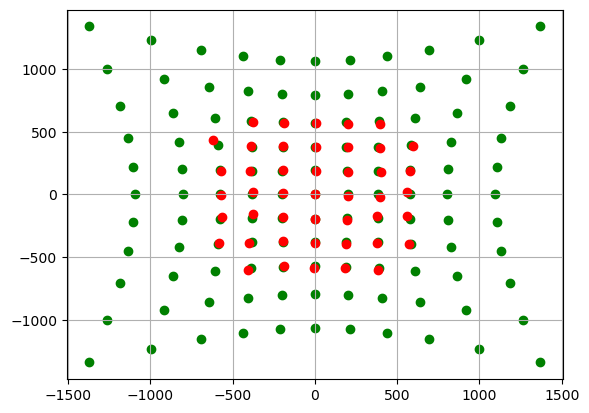

In [51]:
x_axis = [origin[0] - i*x_unit for i in range(-5, 6)]
y_axis = [origin[1] - i*y_unit for i in range(-5, 6)]

xx, yy = np.meshgrid(x_axis, y_axis)
xx, yy = xx[:, ::-1].T, yy.T
undistorted_points = np.zeros([11, 11, 2])
undistorted_points[:, :, 0] = xx
undistorted_points[:, :, 1] = yy
undistorted_points = (undistorted_points - undistorted_points[5, 5]).reshape([-1, 2])

r_ud = np.sqrt((undistorted_points[:, 0])**2  + (undistorted_points[:, 1])**2).reshape(-1)

x_est = undistorted_points[:, 0]*np.sum([kx[i]*r_ud**j for i, j in enumerate(range(0, num_params+1, step))], axis=0) #+ undistorted_points[:, 0]*undistorted_points[:, 1]*kx[-1]*r_ud
y_est = undistorted_points[:, 1]*np.sum([ky[i]*r_ud**j for i, j in enumerate(range(0, num_params+1, step))], axis=0) #+ undistorted_points[:, 0]*undistorted_points[:, 1]*ky[-1]*r_ud
plt.scatter(x_est, y_est, color='green')
plt.scatter(distorted_points[:, 0], distorted_points[:, 1], color='red')
# plt.scatter(undistorted_points[:, 0], undistorted_points[:, 1], color='blue')
plt.grid()

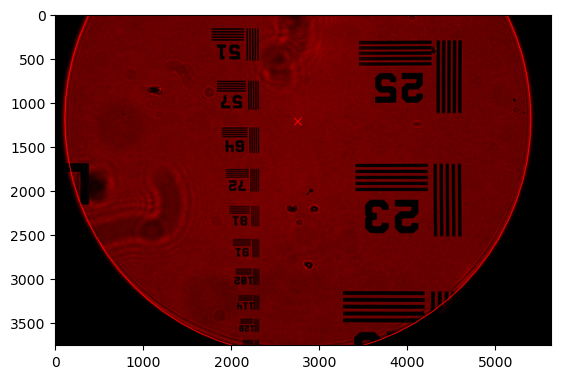

In [79]:
# 15, 15

dir_path = "Z:/CSE\CSE-Research/Microscopy3D/CV_CSE_Collaboration/Results/CV_CSE/fpm_capture/output/2023_03_15/2023_03_15_16_02_07/"
file_path = f"2023_03_15_16_02_07_img_shutter_05_x_15_y_15_r_1_g_0_b_0.tiff"

img = cv2.imread(dir_path + file_path, cv2.IMREAD_UNCHANGED)
b_img, g_img, r_img = cv2.split(img)

g_img_8 = cv2.convertScaleAbs(g_img, alpha=(255/65535))
b_img_8 = cv2.convertScaleAbs(b_img, alpha=(255/65535))
r_img_8 = cv2.convertScaleAbs(r_img, alpha=(255/65535))

temp = np.zeros_like(img, dtype=np.uint8)
temp[:, :, 0] = r_img_8

center_x, center_y = center_cords[15 - 12, 15 - 12]
major_axis_length, minor_axis_length = axis_lens[15 - 12, 15 - 12]
                        
draw_cross(temp, (int(center_x), int(center_y)), (255, 0, 0), length=40, thickness=10)
cv2.ellipse(temp, (int(center_x), int(center_y-30)), (int(major_axis_length), int(minor_axis_length)), 0, 0, 360, (255, 0, 0), 10)

plt.imshow(temp)

In [56]:
img.shape

(3753, 5634, 3)

In [52]:
fit_range = np.loadtxt(f'{save_arr_dir}fit_range.txt').reshape([7, 7])
center_cords = np.loadtxt(f'{save_arr_dir}center.txt').reshape([7, 7, 2])
axis_lens = np.loadtxt(f'{save_arr_dir}axis_lens.txt').reshape([7, 7, 2])


In [13]:
# grid based on tiff images

imgs = []
for x in range(12, 19):
    hstacks = []
    for y in range(12, 19):

        dir_path = "Z:/CSE\CSE-Research/Microscopy3D/CV_CSE_Collaboration/Results/CV_CSE/fpm_capture/output/2023_03_15/2023_03_15_16_02_07/"
        file_path = f"2023_03_15_16_02_07_img_shutter_05_x_{x}_y_{y}_r_0_g_1_b_0.tiff"
        print('x:', x, 'y:', y, file_path)
        
        img = cv2.imread(dir_path + file_path, cv2.IMREAD_UNCHANGED)
        _, g_img, _ = cv2.split(img)


        img_8 = cv2.convertScaleAbs(img, alpha=(255/65535))
        g_img_8 = cv2.convertScaleAbs(g_img, alpha=(255/65535))

        center_x, center_y = center_cords[x - 12, y - 12]
        major_axis_length, minor_axis_length = axis_lens[x - 12, y - 12]
                                
        draw_cross(img_8, (int(center_x), int(center_y)), (0, 0, 255), length=40, thickness=10)
        cv2.ellipse(img_8, (int(center_x), int(center_y)), (int(major_axis_length), int(minor_axis_length)), 0, 0, 360, (0, 0, 255), 10)
        
        # res_img = fit_ellipse_3(file_path, img_8, g_img_8, ifHull=True, method='opencv', save_path=None)
        hstacks.append(img_8)
    imgs.append(np.hstack(hstacks))

x: 12 y: 12 2023_03_15_16_02_07_img_shutter_05_x_12_y_12_r_0_g_1_b_0.tiff
x: 12 y: 13 2023_03_15_16_02_07_img_shutter_05_x_12_y_13_r_0_g_1_b_0.tiff
x: 12 y: 14 2023_03_15_16_02_07_img_shutter_05_x_12_y_14_r_0_g_1_b_0.tiff
x: 12 y: 15 2023_03_15_16_02_07_img_shutter_05_x_12_y_15_r_0_g_1_b_0.tiff
x: 12 y: 16 2023_03_15_16_02_07_img_shutter_05_x_12_y_16_r_0_g_1_b_0.tiff
x: 12 y: 17 2023_03_15_16_02_07_img_shutter_05_x_12_y_17_r_0_g_1_b_0.tiff
x: 12 y: 18 2023_03_15_16_02_07_img_shutter_05_x_12_y_18_r_0_g_1_b_0.tiff
x: 13 y: 12 2023_03_15_16_02_07_img_shutter_05_x_13_y_12_r_0_g_1_b_0.tiff
x: 13 y: 13 2023_03_15_16_02_07_img_shutter_05_x_13_y_13_r_0_g_1_b_0.tiff
x: 13 y: 14 2023_03_15_16_02_07_img_shutter_05_x_13_y_14_r_0_g_1_b_0.tiff
x: 13 y: 15 2023_03_15_16_02_07_img_shutter_05_x_13_y_15_r_0_g_1_b_0.tiff
x: 13 y: 16 2023_03_15_16_02_07_img_shutter_05_x_13_y_16_r_0_g_1_b_0.tiff
x: 13 y: 17 2023_03_15_16_02_07_img_shutter_05_x_13_y_17_r_0_g_1_b_0.tiff
x: 13 y: 18 2023_03_15_16_02_07_img_sh

In [14]:
cv2.imshow('Resized Image', cv2.resize(np.vstack(imgs), (1080, 720), interpolation = cv2.INTER_LINEAR))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [31]:
def manual_fitting(cords, x_est, y_est, undistort_center, major_axis_length, minor_axis_length, angle_degrees = 0):
    xx, yy = cords
    dir_path = "Z:/CSE\CSE-Research/Microscopy3D/CV_CSE_Collaboration/Results/CV_CSE/fpm_capture/output/2023_03_15/2023_03_15_16_02_07/"
    file_path = f"2023_03_15_16_02_07_img_shutter_05_x_{xx}_y_{yy}_r_0_g_1_b_0.tiff"
    print('x:', xx, 'y:', yy, file_path)

    img = cv2.imread(dir_path + file_path, cv2.IMREAD_UNCHANGED)
    img_8 = cv2.convertScaleAbs(img, alpha=(255/65535))

    # Get user input for ellipse parameters
    center_x, center_y = np.array((x_est.reshape([11, 11])[xx-10, yy-10] , y_est.reshape([11, 11])[xx-10, yy-10]) + undistort_center, dtype=np.uint16)

    draw_cross(img_8, (center_x, center_y), (255, 0, 0), length=20, thickness=10)
    cv2.ellipse(img_8, (center_x, center_y), (int(major_axis_length), int(minor_axis_length)), angle_degrees, 0, 360, (255, 0, 0), 5)
    cv2.imshow('Resized Image', cv2.resize(img_8, (1280, 940), interpolation = cv2.INTER_LINEAR))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [32]:
cords = (17, 19)
manual_fitting(cords, x_est, y_est, undistort_center, 2700, 2600)

x: 17 y: 19 2023_03_15_16_02_07_img_shutter_05_x_17_y_19_r_0_g_1_b_0.tiff


In [14]:
for yy in [11, 19]:
    for xx in [12, 13, 14, 15, 17, 18]:
        manual_fitting((xx, yy), x_est, y_est, undistort_center, 2700, 2600)

NameError: name 'manual_fitting' is not defined

In [15]:
for xx in [10, 11, 19]:
    for yy in [12, 13, 14, 15, 16, 17]:
        manual_fitting((xx, yy), x_est, y_est, undistort_center, 2700, 2600)

NameError: name 'manual_fitting' is not defined

In [16]:
new_centers = np.zeros([11, 11, 2])
new_axis_lens = np.zeros([11, 11, 2])

for x in range(12, 19):
    for y in range(12, 19):

        new_centers[x - 10, y - 10] = center_cords[x - 12, y - 19]
        new_axis_lens[x - 10, y - 10] = axis_lens[x - 12, y - 19]

In [16]:
new_centers[0, 0]

array([0., 0.])

In [17]:
for x in range(10, 21):
    for y in range(10, 21):

        if np.array_equal(new_centers[x - 10, y - 10], np.array([0., 0.])):
            new_centers[x - 10, y - 10] = np.array((x_est.reshape([11, 11])[x-10, y-10] , y_est.reshape([11, 11])[x-10, y-10]) + undistort_center, dtype=np.uint16)
            new_axis_lens[x - 10, y - 10] = np.array([2700, 2600])

In [18]:
new_centers[0, 0], new_axis_lens[0, 0]

(array([1388., 2558.]), array([2700., 2600.]))

In [18]:
new_centers[12 - 10, 12 - 10] = np.array((x_est.reshape([11, 11])[12-10, 12-10] , y_est.reshape([11, 11])[12-10, 12-10]) + undistort_center, dtype=np.uint16)
new_centers[12 - 10, 18 - 10] = np.array((x_est.reshape([11, 11])[12-10, 18-10] , y_est.reshape([11, 11])[12-10, 18-10]) + undistort_center, dtype=np.uint16)
new_centers[18 - 10, 12 - 10] = np.array((x_est.reshape([11, 11])[18-10, 12-10] , y_est.reshape([11, 11])[18-10, 12-10]) + undistort_center, dtype=np.uint16)
new_centers[18 - 10, 18 - 10] = np.array((x_est.reshape([11, 11])[18-10, 18-10] , y_est.reshape([11, 11])[18-10, 18-10]) + undistort_center, dtype=np.uint16)

new_axis_lens[12 - 10, 12 - 10] = np.array([2700, 2600])
new_axis_lens[12 - 10, 18 - 10] = np.array([2700, 2600])
new_axis_lens[18 - 10, 12 - 10] = np.array([2700, 2600])
new_axis_lens[18 - 10, 18 - 10] = np.array([2700, 2600])

In [20]:
new_centers[8, 8], new_axis_lens[8, 8]

(array([3363.,  607.]), array([2700., 2600.]))

In [40]:
# grid based on tiff images

imgs = []
for x in range(10, 21):
    vstacks = []
    for y in range(10, 21):

        dir_path = "Z:/CSE\CSE-Research/Microscopy3D/CV_CSE_Collaboration/Results/CV_CSE/fpm_capture/output/2023_03_15/2023_03_15_16_02_07/"
        file_path = f"2023_03_15_16_02_07_img_shutter_05_x_{x}_y_{y}_r_0_g_1_b_0.tiff"
        print('x:', x, 'y:', y, file_path)
        
        img = cv2.imread(dir_path + file_path, cv2.IMREAD_UNCHANGED)
        _, g_img, _ = cv2.split(img)


        img_8 = cv2.convertScaleAbs(img, alpha=(255/65535))
        g_img_8 = cv2.convertScaleAbs(g_img, alpha=(255/65535))

        scale_percent = 0.04 # percent of original size

        center_x, center_y = new_centers[x - 10, y - 10]*scale_percent
        major_axis_length, minor_axis_length = new_axis_lens[x - 10, y - 10]*scale_percent
        
        width = int(img_8.shape[1] * scale_percent)
        height = int(img_8.shape[0] * scale_percent)
        dim = (width, height)
        
        # resize image
        resized = cv2.resize(img_8, dim, interpolation = cv2.INTER_AREA)
        if (x, y) == (10, 10) or (x, y) == (10, 11) or (x, y) == (10, 11) or (x, y) == (10, 12) or (x, y) == (10, 13) or (x, y) == (10, 17) or (x, y) == (10, 18) or (x, y) == (10, 19) or (x, y) == (10, 20) or (x, y) == (11, 10) or (x, y) == (11, 11) or (x, y) == (11, 19) or (x, y) == (11, 20) or (x, y) == (12, 10) or (x, y) == (12, 20)  or (x, y) == (13, 10) or (x, y) == (13, 20) or (x, y) == (14, 20) or (x, y) == (16, 20) or (x, y) == (17, 10) or (x, y) == (17, 20) or (x, y) == (18, 10) or (x, y) == (18, 20) or (x, y) == (19, 10) or (x, y) == (19, 11) or (x, y) == (19, 18) or (x, y) == (19, 19) or (x, y) == (19, 20) or (x, y) == (20, 10) or (x, y) == (20, 11) or (x, y) == (20, 12) or (x, y) == (20, 13) or (x, y) == (20, 14) or (x, y) == (20, 16) or (x, y) == (20, 17) or (x, y) == (20, 18) or (x, y) == (20, 19) or (x, y) == (20, 20):
            pass
        else:
            if x < 12 or x > 18 or y < 12 or y > 18:
                draw_cross(resized, (int(center_x), int(center_y)), (255, 0, 0), length=10, thickness=2)
                cv2.ellipse(resized, (int(center_x), int(center_y)), (int(major_axis_length), int(minor_axis_length)), 0, 0, 360, (255, 0, 0), 3)
            else:
                draw_cross(resized, (int(center_x), int(center_y)), (0, 0, 255), length=10, thickness=2)
                cv2.ellipse(resized, (int(center_x), int(center_y)), (int(major_axis_length), int(minor_axis_length)), 0, 0, 360, (0, 0, 255), 3)
        
        # res_img = fit_ellipse_3(file_path, img_8, g_img_8, ifHull=True, method='opencv', save_path=None)
        # vstacks.append(resized)
        # resized = cv2.resize(resized, (int(width*0.85), height), interpolation = cv2.INTER_AREA)
        pad = np.ones([height+20, width+10, 3], dtype=np.uint8)*255
        pad[10:-10, 5:-5, :] = resized
        vstacks.insert(0, pad)
        # vstacks.insert(0, resized)
    imgs.append(np.vstack(vstacks))

x: 10 y: 10 2023_03_15_16_02_07_img_shutter_05_x_10_y_10_r_0_g_1_b_0.tiff
x: 10 y: 11 2023_03_15_16_02_07_img_shutter_05_x_10_y_11_r_0_g_1_b_0.tiff
x: 10 y: 12 2023_03_15_16_02_07_img_shutter_05_x_10_y_12_r_0_g_1_b_0.tiff
x: 10 y: 13 2023_03_15_16_02_07_img_shutter_05_x_10_y_13_r_0_g_1_b_0.tiff
x: 10 y: 14 2023_03_15_16_02_07_img_shutter_05_x_10_y_14_r_0_g_1_b_0.tiff
x: 10 y: 15 2023_03_15_16_02_07_img_shutter_05_x_10_y_15_r_0_g_1_b_0.tiff
x: 10 y: 16 2023_03_15_16_02_07_img_shutter_05_x_10_y_16_r_0_g_1_b_0.tiff
x: 10 y: 17 2023_03_15_16_02_07_img_shutter_05_x_10_y_17_r_0_g_1_b_0.tiff
x: 10 y: 18 2023_03_15_16_02_07_img_shutter_05_x_10_y_18_r_0_g_1_b_0.tiff
x: 10 y: 19 2023_03_15_16_02_07_img_shutter_05_x_10_y_19_r_0_g_1_b_0.tiff
x: 10 y: 20 2023_03_15_16_02_07_img_shutter_05_x_10_y_20_r_0_g_1_b_0.tiff
x: 11 y: 10 2023_03_15_16_02_07_img_shutter_05_x_11_y_10_r_0_g_1_b_0.tiff
x: 11 y: 11 2023_03_15_16_02_07_img_shutter_05_x_11_y_11_r_0_g_1_b_0.tiff
x: 11 y: 12 2023_03_15_16_02_07_img_sh

In [34]:
resized.dtype

dtype('uint8')

In [36]:
cv2.imshow('Resized Image', np.hstack(imgs))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [37]:
np.hstack(imgs).shape

(1870, 2695, 3)

In [41]:
cv2.imwrite(f'big_figure_hr_5.png', np.hstack(imgs))

True

In [127]:
cv2.imshow('Resized Image', np.hstack(imgs)[::-1, :])
cv2.waitKey(0)
cv2.destroyAllWindows()